# Experimento 6 - Parámetros del Solver

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys

sys.path.append("..")

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Use latex
plt.rc("text", usetex=True)

## Definiciones

In [4]:
from src.generacion import (
    GeneradorInstancias,
    DistribucionIndependiente,
    DistribucionUniforme,
    DistribucionNormal,
)


generador = GeneradorInstancias(
    cantidad_trabajadores=DistribucionUniforme(5, 10),
    cantidad_ordenes=DistribucionUniforme(5, 20),
    parametros_ordenes=DistribucionIndependiente(
        DistribucionNormal(10000, 2000),
        DistribucionUniforme(2, 8),
    ),
    cantidad_ordenes_conflictivas=DistribucionUniforme(0, 4),
    cantidad_ordenes_correlativas=DistribucionUniforme(0, 3),
)

N = 200
instancias = [generador.generar_instancia() for _ in range(N)]

In [5]:
from pprint import pprint

# pprint(instancias[195])

## Experimentos

In [6]:
from graficos import boxplot

### Experimento: Selección de Nodo

In [7]:
from experimento import Experimento
from src.solver import ConfiguracionCPLEX, SeleccionDeNodo

experimentos_seleccion_nodo = {
    seleccion_nodo.name: Experimento(
        nombre=f"seleccion_nodo-{seleccion_nodo.name}",
        instancias=instancias,
        configuracion_solver=ConfiguracionCPLEX(
            estrategia_seleccion_nodo=seleccion_nodo,
        ),
    )
    for seleccion_nodo in SeleccionDeNodo
}

In [8]:
resultados_seleccion_nodo = {
    nombre: experimento.ejecutar()
    for nombre, experimento in experimentos_seleccion_nodo.items()
}

In [9]:
resultados_default = resultados_seleccion_nodo["BEST_BOUND"]

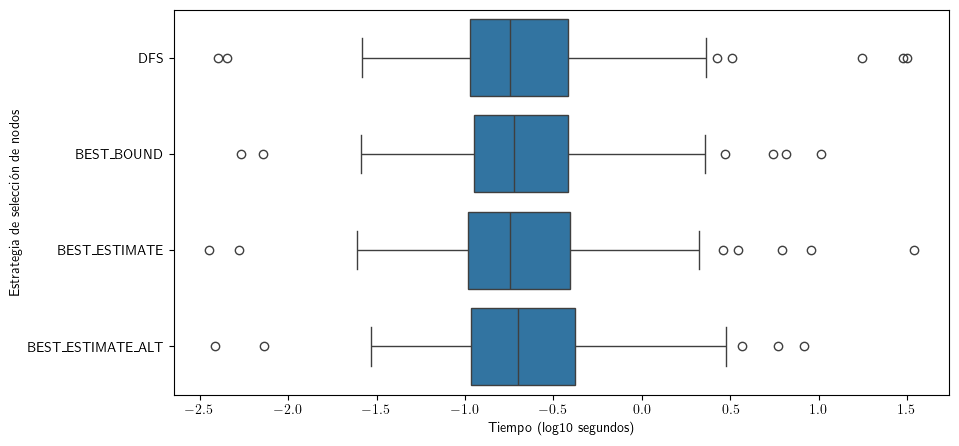

In [9]:
import math

fig = boxplot(
    [
        [math.log10(t) for t in resultados.tiempos]
        for resultados in resultados_seleccion_nodo.values()
    ],
    resultados_seleccion_nodo.keys(),
    xlabel="Tiempo (log10 segundos)",
    ylabel="Estrategia de selección de nodos",
)

fig.savefig("graficos/exp6/seleccion_nodo_distribucion_tiempo.pdf")

### Experimento: Selección de Variable

In [10]:
from src.solver import SeleccionDeVariable


experimentos_seleccion_variable = {
    seleccion_variable.name: Experimento(
        nombre=f"seleccion_variable-{seleccion_variable.name}",
        instancias=instancias,
        configuracion_solver=ConfiguracionCPLEX(
            estrategia_seleccion_variable=seleccion_variable,
        ),
    )
    for seleccion_variable in SeleccionDeVariable
    if seleccion_variable
    not in {
        SeleccionDeVariable.AUTO,
        SeleccionDeVariable.MAX_INFEAS,
        SeleccionDeVariable.PSEUDOCOST_REDUCED,
    }
}

In [11]:
resultados_seleccion_variable = {
    nombre: experimento.ejecutar()
    for nombre, experimento in experimentos_seleccion_variable.items()
} | {"AUTO": resultados_default}

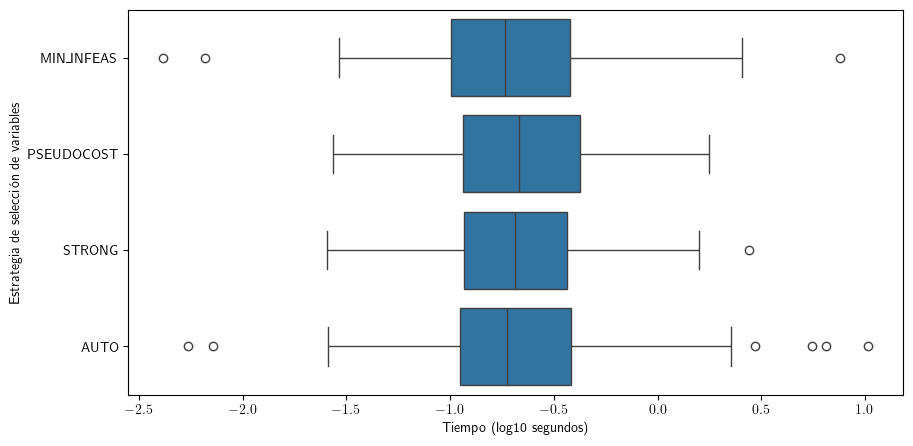

In [40]:
fig = boxplot(
    [
        [math.log10(t) for t in resultados.tiempos]
        for resultados in resultados_seleccion_variable.values()
    ],
    resultados_seleccion_variable.keys(),
    xlabel="Tiempo (log10 segundos)",
    ylabel="Estrategia de selección de variables",
)

fig.savefig("graficos/exp6/seleccion_variable_distribucion_tiempo.pdf")

In [41]:
{
    nombre: pd.Series(resultados.tiempos).mean()
    for nombre, resultados in resultados_seleccion_variable.items()
}

{'MIN_INFEAS': np.float64(0.3196941038849764),
 'PSEUDOCOST': np.float64(0.30264957295003114),
 'STRONG': np.float64(0.2864401314749739),
 'AUTO': np.float64(0.39930811910504416)}

### Experimento: Preprocesamiento

In [44]:
experimento_sin_preprocesamiento = Experimento(
    nombre="sin_preprocesamiento",
    instancias=instancias,
    configuracion_solver=ConfiguracionCPLEX(
        preprocesamiento=False,
    ),
)

In [45]:
resultados_sin_preprocesamiento = experimento_sin_preprocesamiento.ejecutar()

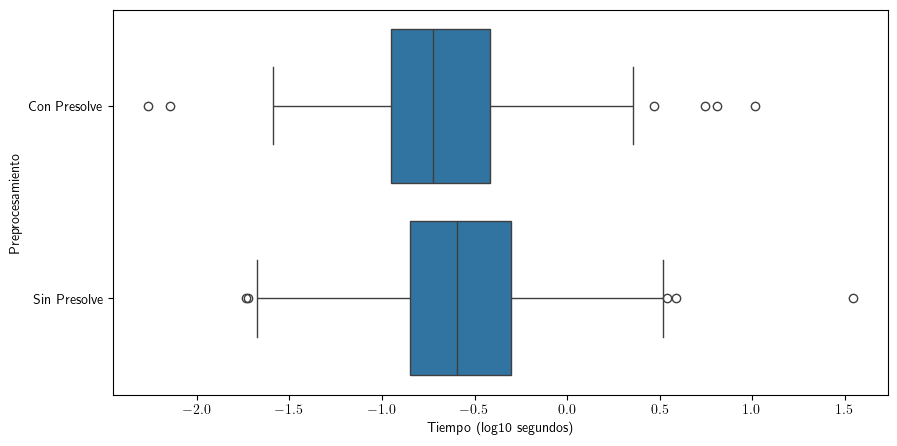

In [58]:
fig = boxplot(
    [
        [math.log10(t) for t in resultados.tiempos]
        for resultados in [
            resultados_default,
            resultados_sin_preprocesamiento,
        ]
    ],
    ["Con Presolve", "Sin Presolve"],
    xlabel="Tiempo (log10 segundos)",
    ylabel="Preprocesamiento",
)

fig.savefig("graficos/exp6/preprocesamiento_distribucion_tiempo.pdf")

In [54]:
pd.Series(resultados_default.tiempos).describe()

count    200.000000
mean       0.399308
std        0.971147
min        0.005449
25%        0.112108
50%        0.188448
75%        0.383543
max       10.339269
dtype: float64

In [55]:
pd.Series(resultados_sin_preprocesamiento.tiempos).describe()

count    200.000000
mean       0.574804
std        2.490624
min        0.018316
25%        0.140836
50%        0.254397
75%        0.499571
max       34.853860
dtype: float64

### Experimento: Heurísticas

In [10]:
experimentos_heuristicas = {
    effort: Experimento(
        nombre=f"heuristicas-{effort}",
        instancias=instancias,
        configuracion_solver=ConfiguracionCPLEX(heuristic_effort=effort),
    )
    for effort in {0.0, 2.0}
}

In [11]:
resultados_heuristicas = {
    nombre: experimento.ejecutar()
    for nombre, experimento in experimentos_heuristicas.items()
} | {1.0: resultados_default}

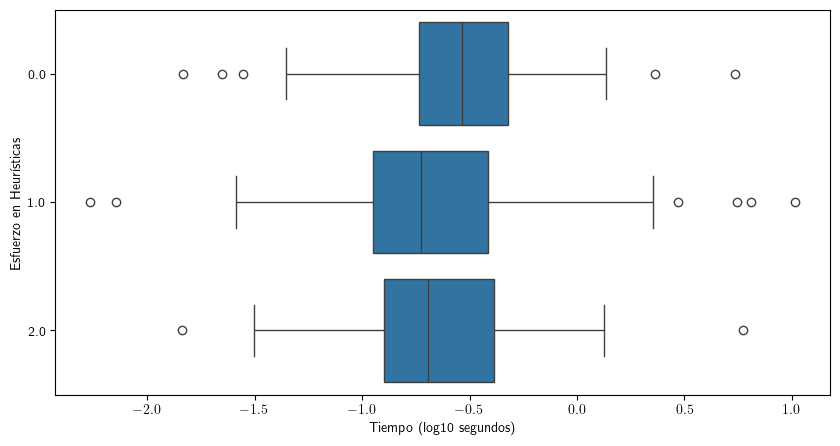

In [15]:
fig = boxplot(
    [
        [math.log10(t) for t in resultados.tiempos]
        for resultados in [
            resultados_heuristicas[0.0],
            resultados_heuristicas[1.0],
            resultados_heuristicas[2.0],
        ]
    ],
    ["0.0", "1.0", "2.0"],
    xlabel="Tiempo (log10 segundos)",
    ylabel=r"Esfuerzo en Heurísticas",
)

fig.savefig("graficos/exp6/heuristicas_distribucion_tiempo.pdf")

### Experimento: Planos de Corte

In [16]:
from src.solver import PlanosDeCorte

parametros_planos_de_corte = [
    "planos_de_corte",
    "gub",
    "gomory",
    "bqp",
    "clique",
    "cover",
    "disjunctive",
]

experimentos_planos_de_corte = {
    parametro: Experimento(
        nombre=f"cortes-{parametro}",
        instancias=instancias,
        configuracion_solver=ConfiguracionCPLEX(
            **{
                p: PlanosDeCorte.AGRESIVO if p == parametro else PlanosDeCorte.NINGUNO
                for p in parametros_planos_de_corte
            }
        ),
    )
    for parametro in parametros_planos_de_corte
}

In [18]:
experimento_todos = Experimento(
    nombre="todos",
    instancias=instancias,
    configuracion_solver=ConfiguracionCPLEX(
        **{p: PlanosDeCorte.AGRESIVO for p in parametros_planos_de_corte}
    ),
)

In [19]:
resultados_planos_de_corte = {
    nombre: experimento.ejecutar()
    for nombre, experimento in experimentos_planos_de_corte.items()
} | {"todos": experimento_todos.ejecutar()}

todos: 100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


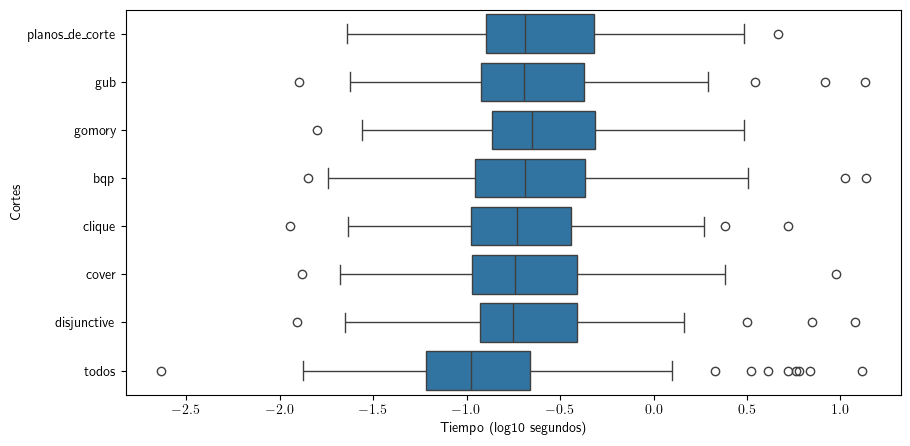

In [20]:
fig = boxplot(
    [
        [math.log10(t) for t in resultados.tiempos]
        for resultados in resultados_planos_de_corte.values()
    ],
    resultados_planos_de_corte.keys(),
    xlabel="Tiempo (log10 segundos)",
    ylabel="Cortes",
)

fig.savefig("graficos/exp6/cortes_distribucion_tiempo.pdf")